# 导入必要的库

In [1]:
import shutil
import numpy as np
from tqdm import tqdm
import time
from accProcess import *
from OpenSeesAnalysis import *
from multiprocessing.dummy import Pool as ThreadPool   #并行计算的库
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Arial'

# 使用OpenSees进行NLT计算

## 准备好输入加速度文件和tcl文件

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[0 : 100]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

## 运行OpenSees

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

## 删除计算文件

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[:100]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 第二轮

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[100 : 200]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[100 : 200]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 第三轮

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[200 : 300]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[200 : 300]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 第四轮

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[300 : 400]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[300 : 400]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 第五轮

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[400 : 500]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[400 : 500]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 第六轮

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[500 : ]
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        mainfilelist.append(event_path)
        inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
        for i in range(acc.shape[0]):
            if direct == 'ew':
                inp.write('%7.6E\n' % acc[i, 1])
            elif direct == 'ns':
                inp.write('%7.6E\n' % acc[i, 2])
        inp.close()

        shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
        tcl_list = os.listdir(tcl_path)
        for f in tcl_list:
            if f.endswith('.tcl'):
                shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
        change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
        change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(8)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[500 : ]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

## 补漏

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list
# station_list = ['AKTH02']
mainfilelist = []
direct = 'ns'
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    vsvp = getProfile(os.path.join(dataset_path, 'sitedat_vs_vp', station + '.dat'))
    vsdata = vsvp[:, [0, 2]]
    vsdata[-1, 0] = station_depth[station]
    # change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(dataset_path, station, 'parameters.tcl'), vsdata)
    for event, acc in pbar:
        dt = float(acc[1, 0] - acc[0, 0])
        event_path = os.path.join(dataset_path, station, event)
        if not os.path.exists(os.path.join(event_path, 'out_%s.acc' % direct)):
            mainfilelist.append(event_path)
            inp = open(os.path.join(event_path, 'inp_%s.acc' % direct), 'w')
            for i in range(acc.shape[0]):
                if direct == 'ew':
                    inp.write('%7.6E\n' % acc[i, 1])
                elif direct == 'ns':
                    inp.write('%7.6E\n' % acc[i, 2])
            inp.close()

            shutil.copyfile(os.path.join(tcl_path, 'OpenSees.exe'), os.path.join(event_path, 'OpenSees.exe'))
            tcl_list = os.listdir(tcl_path)
            for f in tcl_list:
                if f.endswith('.tcl'):
                    shutil.copyfile(os.path.join(tcl_path, f), os.path.join(event_path, f))
            change_analysis(os.path.join(tcl_path, 'analysis.tcl'), event_path, 'inp_%s.acc' % direct, 'out_%s.acc' % direct, acc.shape[0], dt)
            change_paras(os.path.join(tcl_path, 'parameters.tcl'), os.path.join(event_path, 'parameters.tcl'), vsdata)

print('Total simulation: %d' % len(mainfilelist))

In [ ]:
print('Total simulation: %d' % len(mainfilelist))
start = time.time()
print('OpenSees Running ...')
# 并行运行OpenSees
pool = ThreadPool(7)
pool.map(runOpenSees, mainfilelist)
pool.close()
pool.join()
print('OpenSees Running Time: {tt:.2f}'.format(tt=time.time() - start))

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
station_depth = np.load('station_depth.npy', allow_pickle=True).item()
tcl_path = 'NLT_model/tclfile'
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[400 : 500]


dataset_path = 'E:/Ground_motion_database/KiK-net'
# station_list = ['IBRH13']
for station in station_list:
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    pbar = tqdm(data.items(), desc=station, ncols=100)
    for event, acc in pbar:
        event_path = os.path.join(dataset_path, station, event)
        if os.path.exists(os.path.join(event_path, 'OpenSees.exe')):
            os.remove(os.path.join(event_path, 'OpenSees.exe'))
        flist = os.listdir(event_path)
        for f in flist:
            if f.endswith('.tcl') or 'inp_' in f:
                os.remove(os.path.join(event_path, f))

# 处理计算好的结果

## 绘制指定地震的模拟结果图

In [ ]:
dataset_path = 'E:/Ground_motion_database/KiK-net'
event = 'IBUH012003280958'
station = event[:6]
data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
acc = data[event]
dt = float(acc[1, 0] - acc[0, 0])
simu = np.loadtxt(os.path.join(dataset_path, station, event, 'out_ew.acc'))
simu = simu / 9.81 + acc[:, 1]

period = np.logspace(np.log10(1/15), np.log10(10), 100)
sa_up, _, _ = response_spectra_py(acc[:, 4], dt, period)
sa_md, _, _ = response_spectra_py(simu, dt, period)

plt.figure(figsize=(10, 4))
plt.plot(acc[:, 0], acc[:, 4], linewidth=1, label='record')
plt.plot(acc[:, 0], simu, '--', linewidth=1, label='simulate')
plt.legend()
# plt.xlim([30, 32])

plt.figure(figsize=(8, 6))
plt.semilogx(period, sa_up, label='record')
plt.semilogx(period, sa_md, label='simulate')
plt.legend()

## 将每个台站模拟的结果保存到字典中，类似于acc_Prism.npy文件

In [ ]:
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[0:]

count = 0
bad_events = []
pbar = tqdm(station_list, desc='Process', ncols=100)
for station in pbar:
    acc_simu = {}
    data = np.load(os.path.join(dataset_path, station, 'acc_Prism.npy'), allow_pickle=True).item()
    for event, acc in data.items():
        pbar.set_description(event)
        simu = np.loadtxt(os.path.join(dataset_path, station, event, 'out_ns.acc'))
        if len(simu) != acc.shape[0]:
            bad_events.append(event)
            count += 1
        else:
            acc_simu[event] = simu / 9.81 + acc[:, 1]
    np.save(os.path.join(dataset_path, station, 'accNS_simu.npy'), acc_simu)
print('Total number %d' % count)

## 求所有模拟结果的反应谱和傅里叶谱，并保存在字典里

In [ ]:
station_events = np.load('event.npy', allow_pickle=True).item()
station_list = list(station_events.keys())
station_list = station_list[0:]

FTS_simulate = {}
Sa_simulate = {}
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
period = np.logspace(np.log10(0.01), np.log10(10), 200)
coef = int(0.2 * len(freq))

pbar = tqdm(station_list, desc='Process', ncols=100)
for station in pbar:
    acc_simu = np.load(os.path.join(dataset_path, station, 'accNS_simu.npy'), allow_pickle=True).item()
    for event, acc in acc_simu.items():
        pbar.set_description(event)
        if os.path.exists(os.path.join(dataset_path, station, event, event + 'EW_dh_005.acc')):
            dt = 0.005
        else:
            dt = 0.01
        _, fts = getFourierSpectrum(acc, dt, freq, smooth='movemean', coef=coef)
        sa = getResponseSpectrum(acc, dt, period)
        FTS_simulate[event] = fts
        Sa_simulate[event] = sa

np.save('FTS_simulate_ns.npy', FTS_simulate)
np.save('Sa_simulate_ns.npy', Sa_simulate)

# 模拟结果和实测结果的对比

## 获取数据并计算残差

In [28]:
period = np.logspace(np.log10(0.01), np.log10(10), 200)
period_sec = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0]
data_scale = 'log'

simu_data = np.load('Sa_simulate.npy', allow_pickle=True).item()
record_data = np.load('Sa_up_stations.npy', allow_pickle=True).item()
event_list = np.load('event.npy', allow_pickle=True).item()
event_msg = np.load('event_msg.npy', allow_pickle=True).item()
vs30_data = np.load('vs30.npy', allow_pickle=True).item()
source_data = np.load('source.npy', allow_pickle=True).item()

sa_simu = np.zeros((len(simu_data), len(period)))
sa_record = np.zeros((len(simu_data), len(period)))
PGA = np.zeros(len(simu_data))
vs30 = np.zeros(len(simu_data))
source = np.zeros((len(simu_data), 3))
event_simu = list(simu_data.keys())

count = 0
pbar = tqdm(event_list.items(), desc='Processing', ncols=100)
for sta, events in pbar:
    pbar.set_description(sta)
    for i, ev in enumerate(events):
        if ev in event_simu:
            sa_simu[count, :] = 981 * simu_data[ev]
            sa_record[count, :] = record_data[sta][i, :, 0]
            PGA[count] = event_msg[ev][13]
            vs30[count] = vs30_data[sta]
            source[count] = source_data[ev].ravel()
            count += 1

# 计算残差
resi_type = 'log'
if resi_type == 'abs':
    residual = sa_simu - sa_record
elif resi_type == 'rel':
    residual = (sa_simu - sa_record) / sa_record
elif resi_type == 'log':
    residual = np.log(sa_simu) - np.log(sa_record)
label = np.log(sa_simu)[..., None]
pred = np.log(sa_record)[..., None]
residual = residual[..., None]

model_path = 'NLT_model'
figure_path = 'results_figs'
fig_fmt = 'png'

YMTH14: 100%|█████████████████████████████████████████████████████| 525/525 [00:41<00:00, 12.68it/s]


## 不同周期下模拟结果和实测结果的对比图

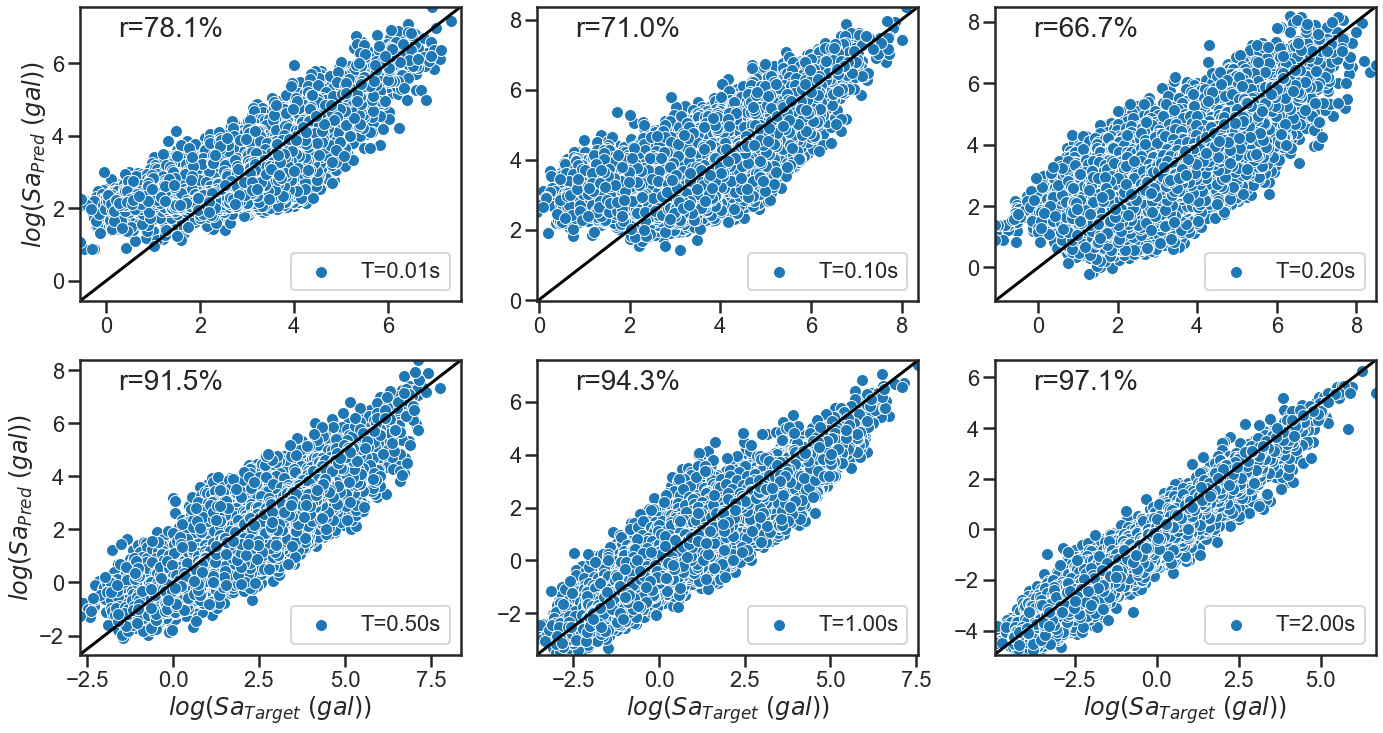

In [29]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    r = np.corrcoef(label_points, pred_points)[0, 1]
    xmin = np.min([np.min(label_points), np.min(pred_points)])
    xmax = np.max([np.max(label_points), np.max(pred_points)])
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=label_points, y=pred_points, label='T=%.2fs' % T)
    plt.plot([xmin, xmax], [xmin, xmax], 'k', linewidth=3)
    plt.text(0.9 * xmin + 0.1 * xmax, 0.1 * xmin + 0.9 * xmax, 'r=%.1f%%' % (100 * r), size=28)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    if i >= 3:
        plt.xlabel('$log(Sa_{Target}\ (gal))$')
    if i in [0, 3]:
        plt.ylabel('$log(Sa_{Pred}\ (gal))$')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_T_compare.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 绘制残差分布图

### 残差随周期的分布图

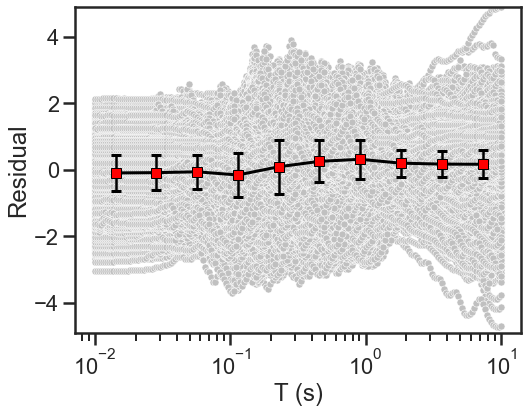

In [30]:
N = len(period)
num_bar = 10
t_err, mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
for i in range(num_bar):
    t_err[i] = period[int((i + 0.5) * N / num_bar)]
    mean_err[i] = np.mean(residual[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])
    std_err[i] = np.std(residual[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.tile(period, residual.shape[0]), y=residual[..., 0].ravel(), s=50, color='silver')
plt.errorbar(t_err, mean_err, std_err, fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
plt.ylim([-np.max(np.abs(residual[..., 0].ravel())), np.max(np.abs(residual[..., 0].ravel()))])
plt.xscale('log')
plt.xlabel('T (s)')
plt.ylabel('Residual')
plt.savefig(os.path.join(model_path, figure_path, 'residual_T.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随地表PGA的分布图

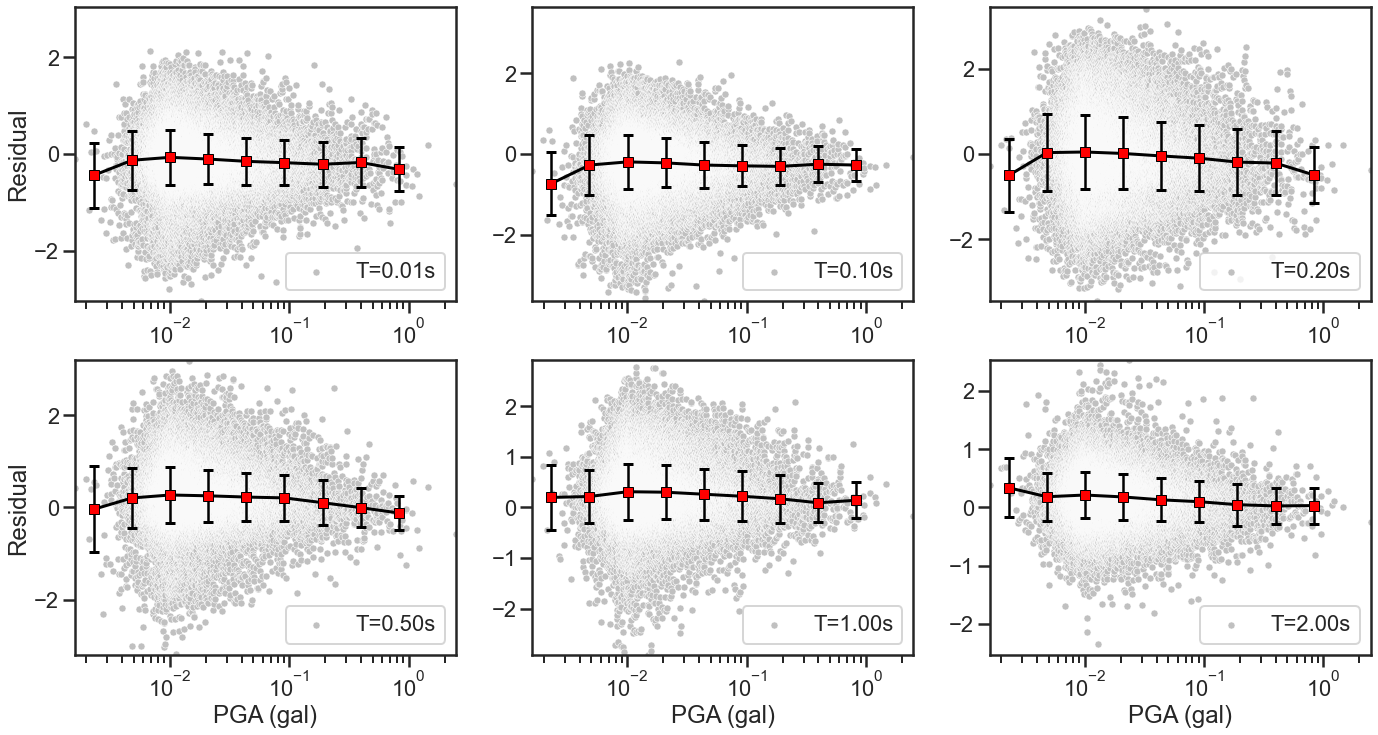

In [31]:
value_list = PGA

# 将所有地震的PGA按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp((np.arange(num_bar) + 0.5) * value_step + np.log(value_min))
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随PGA的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points = residual[:, idx, 0]
    residual_points = residual_points[sort_idx]

    mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err[j] = np.mean(residual_points[idx_err[j]])
        std_err[j] = np.std(residual_points[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=residual_points, label='T=%.2fs' % T, s=50, color='silver')
    plt.errorbar(value_err[:-1], mean_err[:-1], std_err[:-1], fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
    plt.xlim([value_min, value_max])
    plt.ylim([-np.max(np.abs(residual_points)), np.max(np.abs(residual_points))])
    if i >= 3:
        plt.xlabel('PGA (gal)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, figure_path, 'residual_PGA.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随$v_{s30}$的分布图

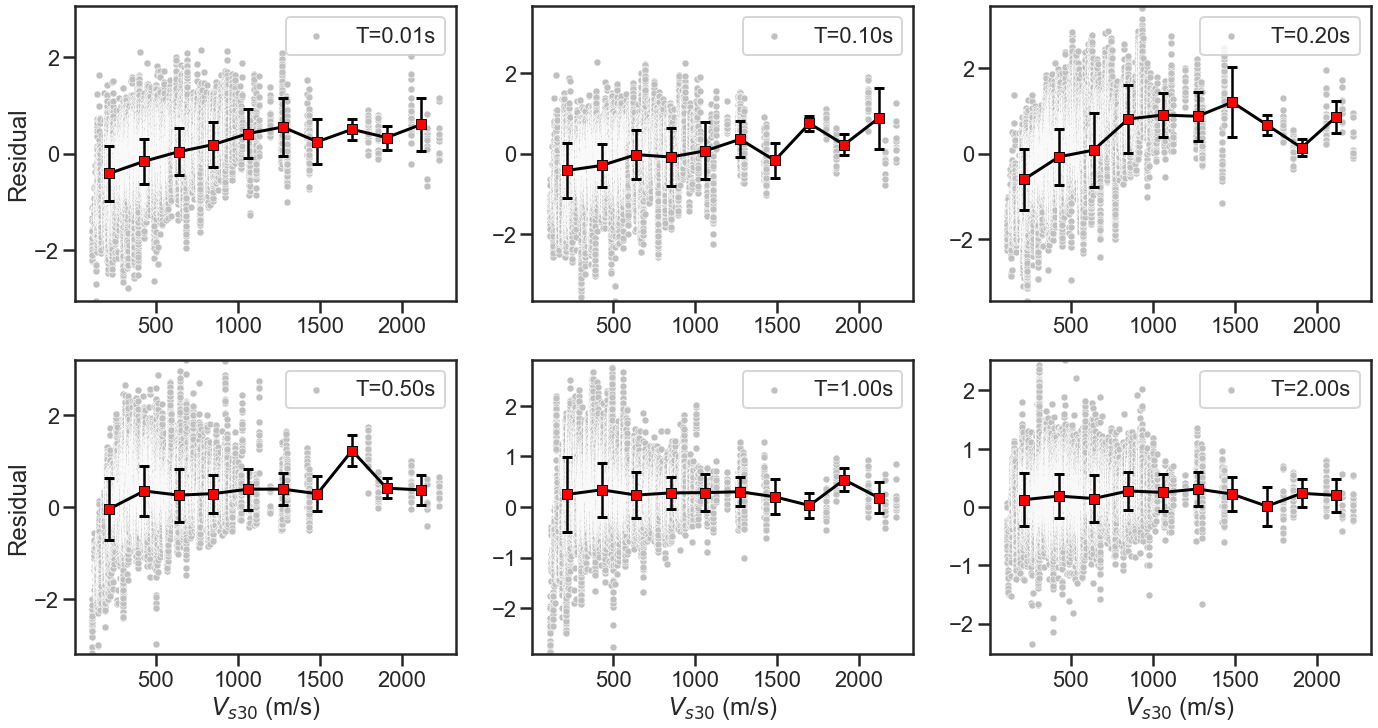

In [32]:
value_list = vs30
# 将所有地震对应的Vs30按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (value_max - value_min) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = value_min + (np.arange(num_bar) + 0.5) * value_step
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if value >= value_min + i * value_step and value < value_min + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随Vs30的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points = residual[:, idx, 0]
    residual_points = residual_points[sort_idx]

    mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err[j] = np.mean(residual_points[idx_err[j]])
        std_err[j] = np.std(residual_points[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=residual_points, label='T=%.2fs' % T, s=50, color='silver')
    plt.errorbar(value_err, mean_err, std_err, fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
    # plt.xlim([value_min, value_max])
    plt.ylim([-np.max(np.abs(residual_points)), np.max(np.abs(residual_points))])
    if i >= 3:
        plt.xlabel('$V_{s30}$ (m/s)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.legend(loc='upper right')
plt.savefig(os.path.join(model_path, figure_path, 'residual_vs30.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震级的分布图

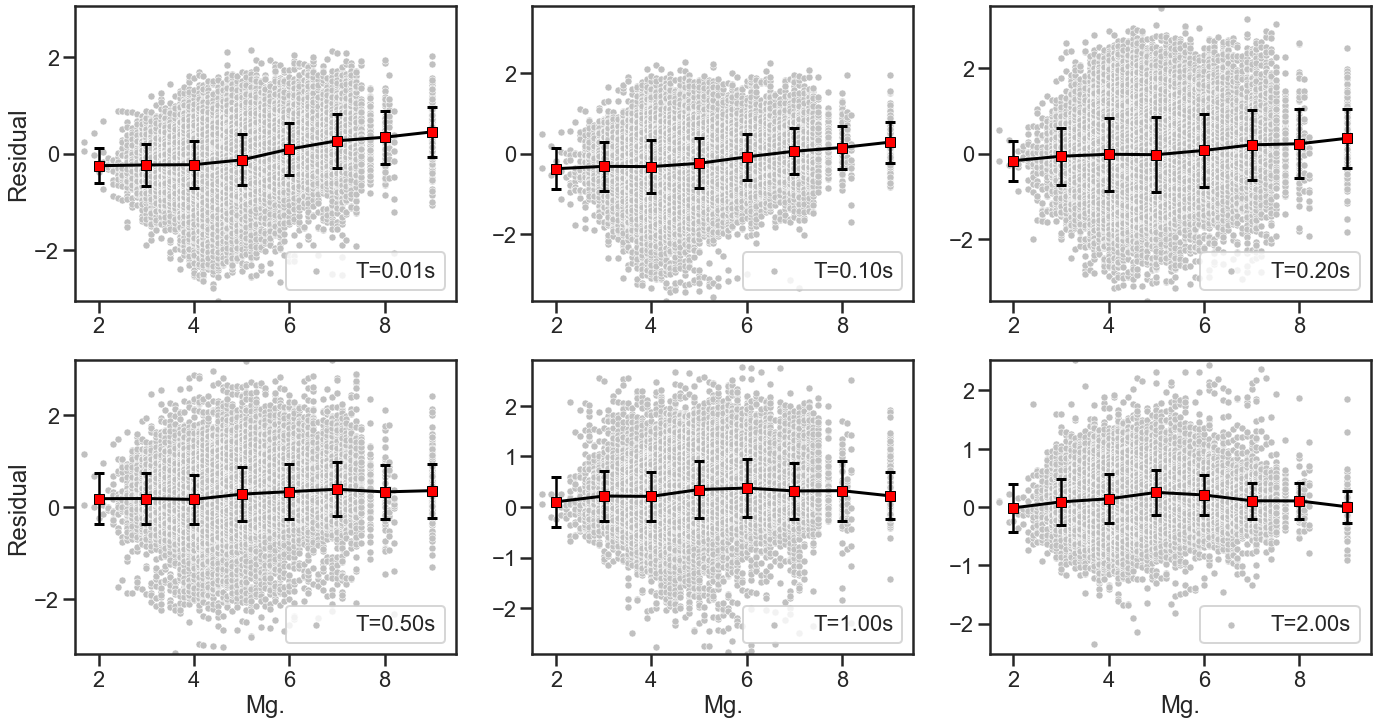

In [33]:
# 获取震级列表
value_list = source[:, 0]

# 将所有地震对应的震级按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.round(np.min(value_list)) - 0.5
value_max = np.round(np.max(value_list)) + 0.5
value_step = 1
num_bar = int((value_max - value_min) / value_step)
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.arange(int(value_min + 0.5), int(value_max + 0.5))
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if value >= value_min + i * value_step and value < value_min + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震级的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points = residual[:, idx, 0]
    residual_points = residual_points[sort_idx]

    mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err[j] = np.mean(residual_points[idx_err[j]])
        std_err[j] = np.std(residual_points[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=residual_points, label='T=%.2fs' % T, s=50, color='silver')
    plt.errorbar(value_err, mean_err, std_err, fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
    plt.xlim([value_min, value_max])
    plt.ylim([-np.max(np.abs(residual_points)), np.max(np.abs(residual_points))])
    if i >= 3:
        plt.xlabel('Mg.')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, figure_path, 'residual_Mg.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震源深度的分布图

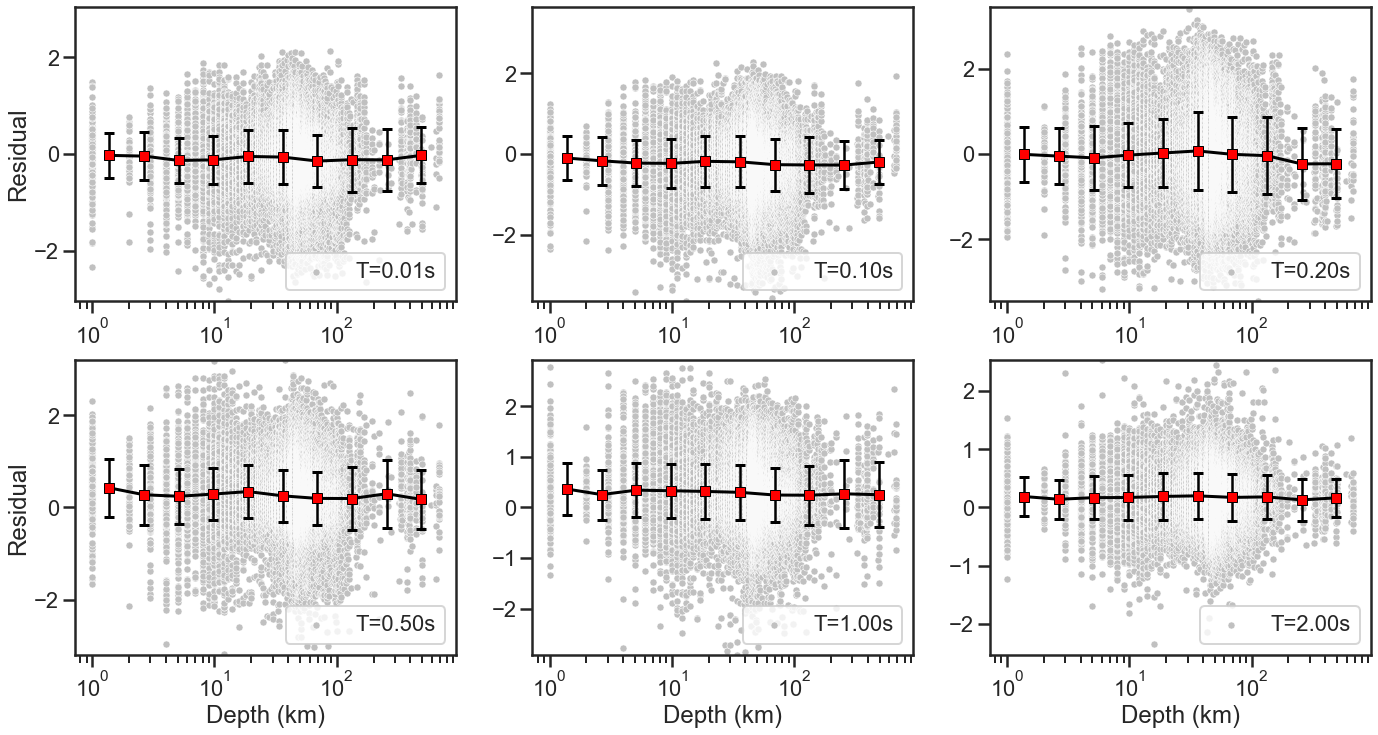

In [34]:
# 获取震源深度列表
depth_list = source[:, 1]
depth_list[depth_list < 1.0] = 1.0
value_list = depth_list

# 将所有地震对应的震源深度按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp(np.log(value_min) + (np.arange(num_bar) + 0.5) * value_step)
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震源深度的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points = residual[:, idx, 0]
    residual_points = residual_points[sort_idx]

    mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err[j] = np.mean(residual_points[idx_err[j]])
        std_err[j] = np.std(residual_points[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=residual_points, label='T=%.2fs' % T, s=50, color='silver')
    plt.errorbar(value_err, mean_err, std_err, fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
    # plt.xlim([0.8 * value_min, 1.1 * value_max])
    plt.ylim([-np.max(np.abs(residual_points)), np.max(np.abs(residual_points))])
    if i >= 3:
        plt.xlabel('Depth (km)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, figure_path, 'residual_Depth.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震中距的分布图

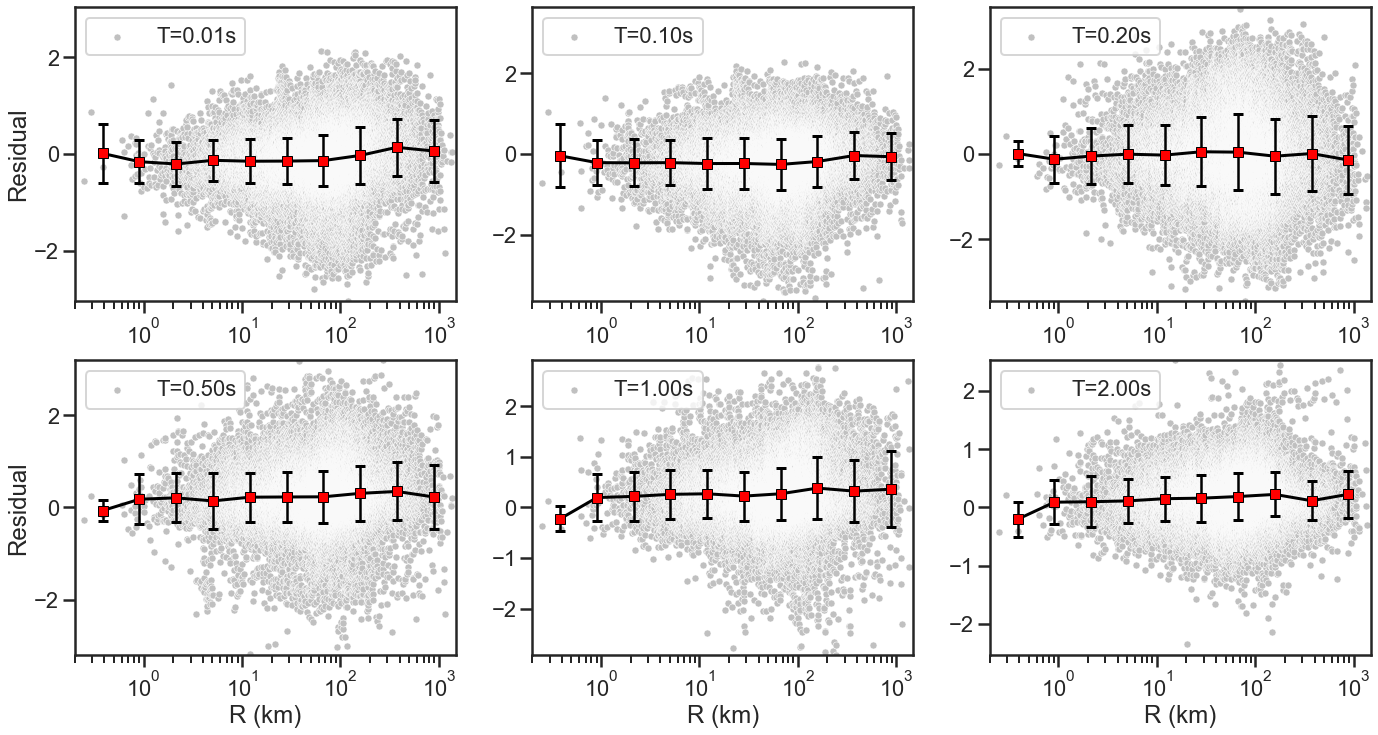

In [35]:
# 获取震中距列表
value_list = source[:, 2]

# 将所有地震对应的震中距按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp(np.log(value_min) + (np.arange(num_bar) + 0.5) * value_step)
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震中距的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points = residual[:, idx, 0]
    residual_points = residual_points[sort_idx]

    mean_err, std_err = np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err[j] = np.mean(residual_points[idx_err[j]])
        std_err[j] = np.std(residual_points[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=residual_points, label='T=%.2fs' % T, s=50, color='silver')
    plt.errorbar(value_err, mean_err, std_err, fmt='s-', ecolor='k', ms=10, mfc='r', mec='k', color='k', elinewidth=2.5, capsize=5, capthick=3)
    plt.xlim([0.8 * value_min, 1.1 * value_max])
    plt.ylim([-np.max(np.abs(residual_points)), np.max(np.abs(residual_points))])
    if i >= 3:
        plt.xlabel('R (km)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, figure_path, 'residual_Rup.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 绘制label和prediction的散点对比图

### 随周期的变化图

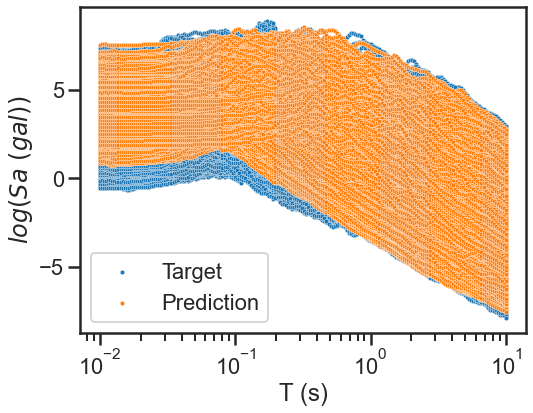

In [36]:
ymin = np.min([np.min(label[..., 0].ravel()), np.min(pred[..., 0].ravel())])
ymax = np.max([np.max(label[..., 0].ravel()), np.max(pred[..., 0].ravel())])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.tile(period, label.shape[0]), y=label[..., 0].ravel(), s=20, label='Target')
sns.scatterplot(x=np.tile(period, label.shape[0]), y=pred[..., 0].ravel(), s=20, label='Prediction')
# plt.ylim([ymin, 0.2 * ymax])
plt.xscale('log')
plt.xlabel('T (s)')
plt.ylabel('$log(Sa\ (gal))$')
plt.legend()
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_T.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随地表PGA的变化图

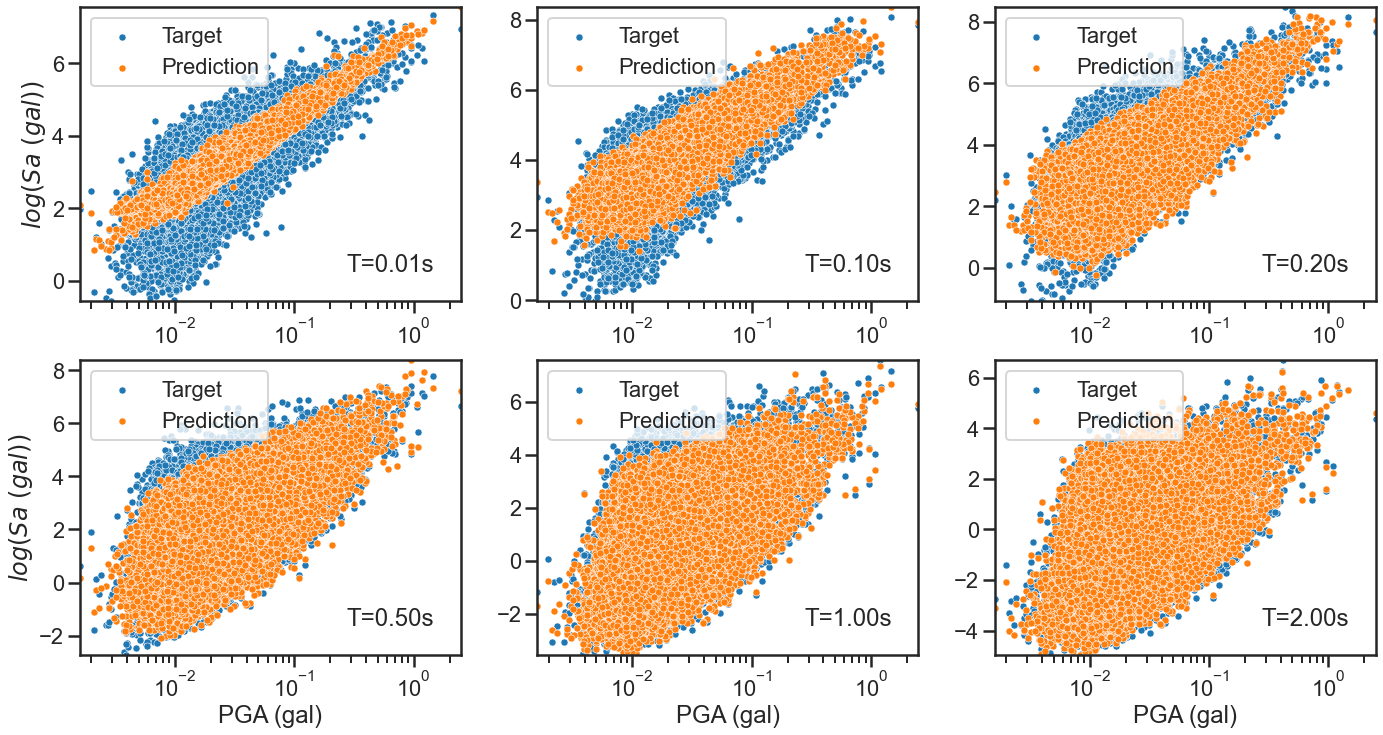

In [37]:
value_list = PGA

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50)
    sns.scatterplot(x=value_list, y=pred_points, label='Prediction', s=50)
    plt.text(value_min ** 0.3 * value_max ** 0.7, ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    plt.xlim([value_min, value_max])
    plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('PGA (gal)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_PGA.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随$v_{s30}$的变化图

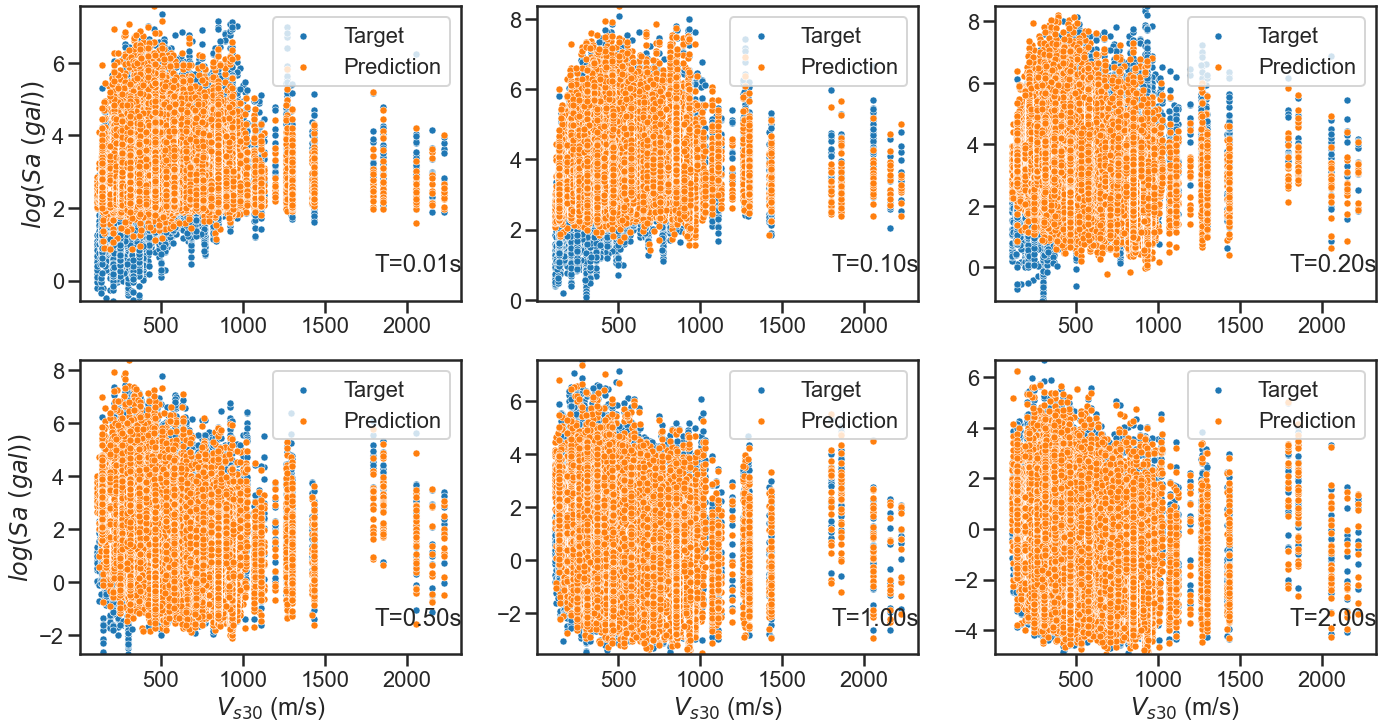

In [38]:
value_list = vs30

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50)
    sns.scatterplot(x=value_list, y=pred_points, label='Prediction', s=50)
    plt.text(value_max - 0.2 * (value_max - value_min), ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('$V_{s30}$ (m/s)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.legend(loc='upper right')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_vs30.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震级的变化图

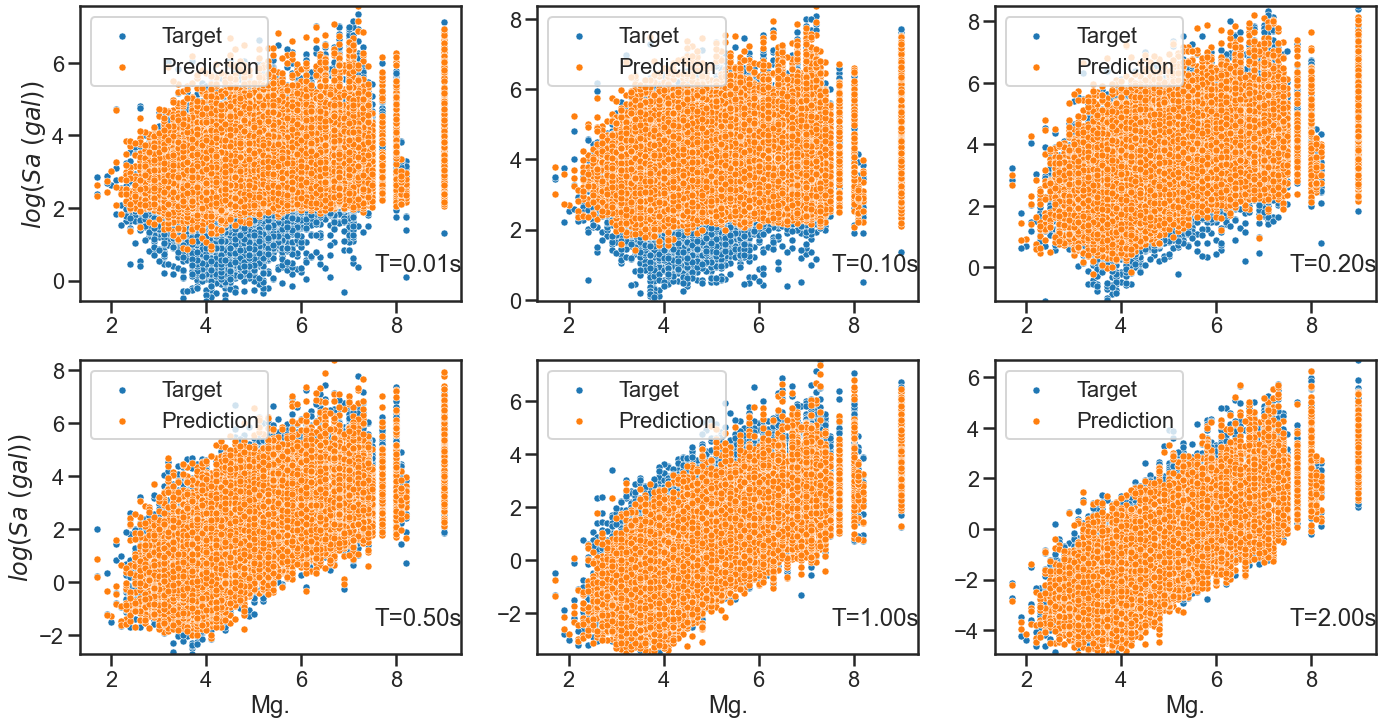

In [39]:
# 获取震级列表
value_list = source[:, 0]

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50)
    sns.scatterplot(x=value_list, y=pred_points, label='Prediction', s=50)
    plt.text(value_max - 0.2 * (value_max - value_min), ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Mg.')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_Mg.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震源深度的变化图

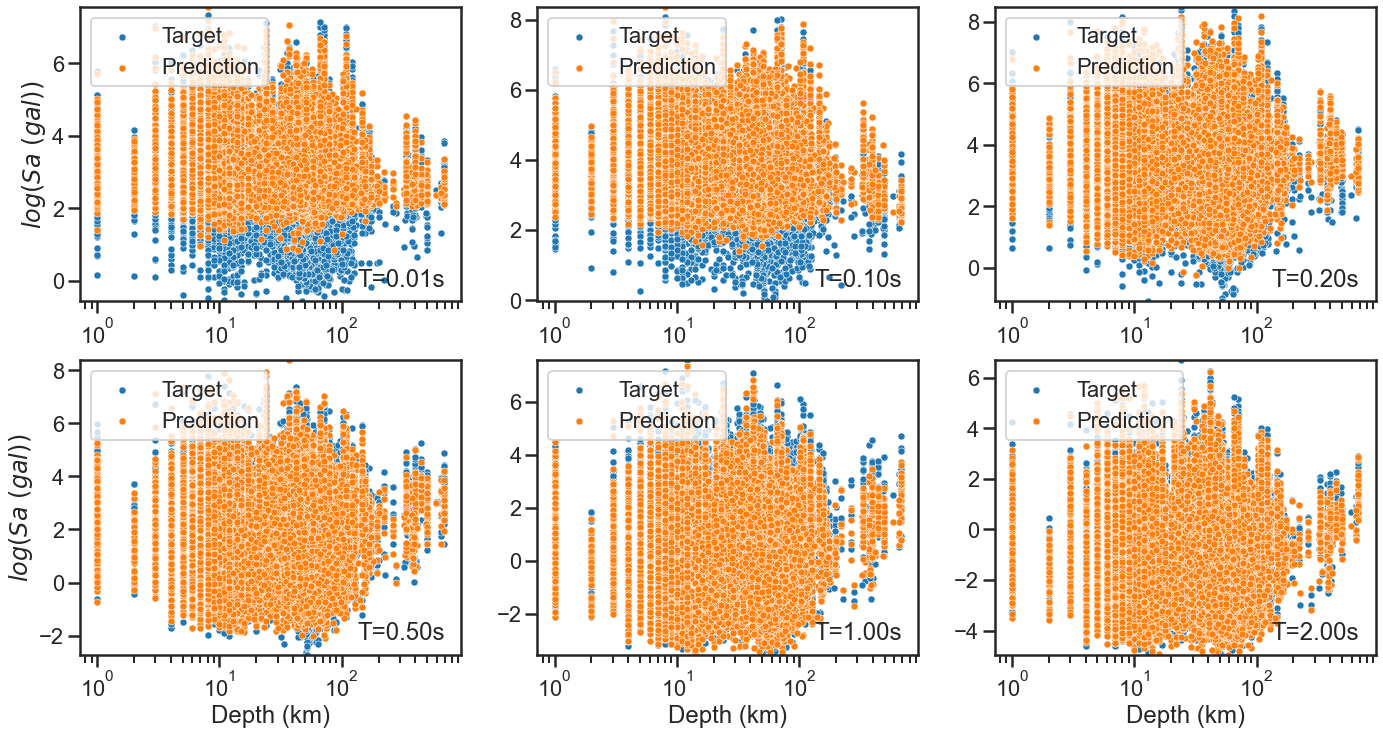

In [40]:
# 获取震源深度列表
value_list = source[:, 1]
value_list[value_list < 1.0] = 1.0

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50)
    sns.scatterplot(x=value_list, y=pred_points, label='Prediction', s=50)
    plt.text(value_max ** 0.75 * value_min ** 0.25, ymin + 0.05 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Depth (km)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_Depth.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震中距的变化图

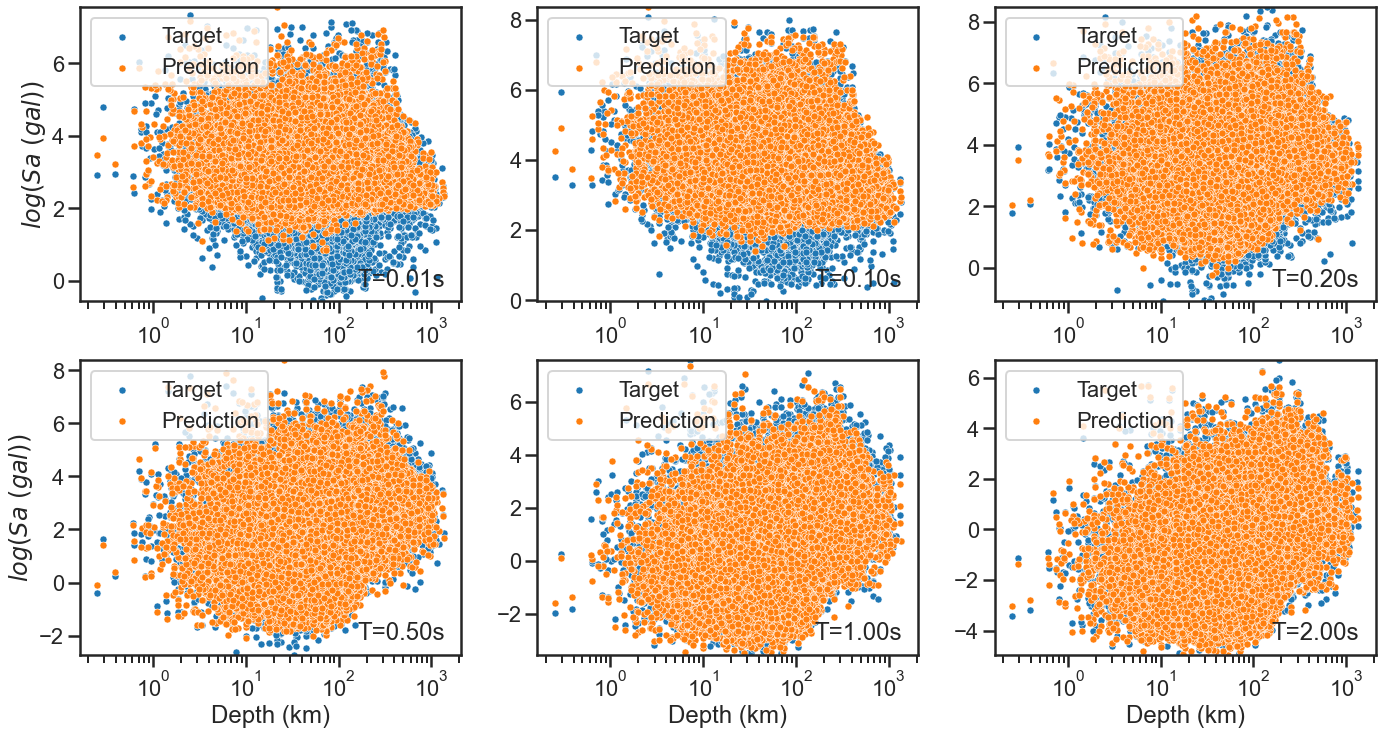

In [41]:
# 获取震中距列表
value_list = source[:, 2]

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50)
    sns.scatterplot(x=value_list, y=pred_points, label='Prediction', s=50)
    plt.text(value_max ** 0.75 * value_min ** 0.25, ymin + 0.05 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Depth (km)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, figure_path, 'Sa_scatter_Rup.%s' % fig_fmt), dpi=300, bbox_inches='tight')